# **Image duplicate finder with FiftyOne and FastAI**

Welcome everyone! I'm super excited to walk you through the code. I've tried my best to give thorough code description here, but if something is unclear, please go through the blog post. [Here's the link to the post](https://medium.com/@dissagaliyeva/image-duplicate-finder-with-fiftyone-and-fastai-217c26ef3802?source=user_profile---------0-------------------------------).


Happy coding!


---

*P.S. if you get stuck or just want to ask something, don't be afraid to send me a message :)*


In [4]:
# install this, otherwise fiftyone import will break
!pip uninstall opencv-python-headless
!pip install opencv-python-headless==4.1.2.30

# uncomment this section 
!pip install fiftyone
!pip install -qq git+https://github.com/fastai/fastai
!pip install fastbook
!pip install split-folders
!pip install imagehash

In [6]:
import os
import shutil
import numpy as np
import seaborn as sns

# package for finding similarity
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F
import fiftyone.core.utils as fou
import fiftyone.brain as fob

from fastbook import *
import fastai

import splitfolders
from PIL import Image 
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import imagehash

import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

NumExpr defaulting to 2 threads.


In [7]:
import warnings
warnings.filterwarnings("ignore")

### **Sign-in to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [8]:
# set path to save images
PATH = '/content/drive/MyDrive/projects/image_duplicates'

### **Alternative option**

In [ ]:
# If you don't want to connect GDrive, use this:
# PATH = 'image_duplicates/' 

### **Create the folders**

In [ ]:
# create a folder where images will be stored 
if not os.path.exists(PATH):
  os.mkdir(PATH)

if not os.path.exists(os.path.join(PATH, 'data')):
  os.mkdir(os.path.join(PATH, 'data'))

## **Utils**

These are the functions needed throughout the notebook. If you want to go through them one by one, you are more than welcome to do so. Otherwise, you can just run them and let the magic work 🧙

### **Folder investigation**

In [9]:
def investigate(path):
  """
  This function reads in all the images in a specified path, stores a short 
  summary of image distributions (count of instances in each class)
  and a dataframe representation of image files along with their target.
    :param path: Path to a folder

  :returns: Two dataframes with short and long descriptions
  """
  # verify folder existance
  assert os.path.exists(path), 'Wrong path provided.'

  # get folder names
  contents = os.listdir(path)
  # create empty holders 
  content_dict = {}
  all_images = []
  classes = []

  # go over the folders and store the length
  for content in contents:
      files = os.listdir(os.path.join(path, content))
      content_dict[content] = len(files)
      # get all image names 
      all_images.append(files)
      classes.append([content for _ in range(len(files))])

  # flatten the array 
  if len(all_images) > 0:
      all_images = [img for x in all_images for img in x]
      classes = [cl for c in classes for cl in c]

  return (pd.DataFrame({'name': content_dict.keys(), 'length': content_dict.values()}), 
  pd.DataFrame({'image_name': all_images, 'class': classes}))


### **Download images**

In [10]:
def download_images(name, path, count=100):
  """
  Find and download images. By default it downloads 100 images. 
    :param name: Name of the images to download 
    :param path: Path to a folder to store images 
    :param count: Number of images to download
  """
  # make sure to download images in the 'data' folder
  path = os.path.join(path, 'data') if not path.endswith('/data') else path
  if not os.path.exists(path): os.mkdir(path)

  # create a folder with the name specified
  dir = os.path.join(path, name)
  if not os.path.exists(dir): os.mkdir(dir)

  # find images
  urls = search_images_ddg(name, max_images=count)

  # get image name & remove unnecessary info
  get_img_name = lambda x: x.split('/')[-1] if '.' not in x else x.split('/')[-1].split('.')[0]

  # download images to the drive/temp folder
  for img in urls:
    try:
      download_url(img, os.path.join(dir, get_img_name(img) + '.jpg'), 
                   show_progress=False)
    except HTTPError:
      continue  
    except URLError:
      continue
    except Exception:
      continue
  
  # drop all the broken images 
  verify_images(get_image_files(dir)).map(Path.unlink)

def show_img(path):
  """
  Randomly choose an image from a folder and display. 
    :param path: Path to a folder  
  """
  name = np.random.choice(os.listdir(os.path.join(path, 'data')))
  img = np.random.choice(os.listdir(os.path.join(path, 'data', name)))
  
  plt.title(name.title())
  plt.imshow(Image.open(os.path.join(path, 'data', name, img)))
  plt.axis('off')
  plt.show()
  

### **Train CNN**

In [11]:
# create a dataloader 
def get_data_loader(path, bs=16, img_size=256, shuffle=True, folder='output'):
  datablock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                        get_items=partial(get_image_files, folders=['train', 'val']),
                        splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                        get_y=parent_label,
                        item_tfms=[Resize((img_size, img_size), method='pad', pad_mode='zeros'), 
                                   ToTensor()],
                        batch_tfms=[*aug_transforms(flip_vert=True, max_rotate=15, 
                                                    pad_mode='zeros', max_lighting=0.6), 
                                   Normalize.from_stats(*imagenet_stats)])
  return datablock.dataloaders(os.path.join(path, folder), bs=bs, 
                               drop_last=True, shuffle=shuffle)

def train_model(path, folder='output', bs=16, img_size=256, shuffle=True, 
                freeze=3, epochs=10, model=resnet50):
  """
  Train and save best model. 
    :param path:     Path to a folder (has to have train/val folders)
    :param bs:       Batch size, default=16
    :param img_size: Image size, default: 256x256
    :param shuffle:  Whether to shuffle data, default: true
    :param freeze:   Number of epochs to train for with frozen layers, default=3
    :param epochs:   Number of epochs to train the whole model for, default=10
    :param model:    Model to train with, default=ResNet50
   
  :return: DataLoader (dls) and trained model (learn)
  """
  model_name = str(model).split(' ')[1]

  print(f"""
  ===== Start training =====
  Epochs: {epochs}
  Model: {model_name}
  Freeze epochs: {freeze}
  Batch size: {bs}
  """)
  
  # get the dataloader 
  dls = get_data_loader(path, bs, img_size, shuffle, folder)
  # create a model, save with the highest accuracy and F1 score
  learn = cnn_learner(dls, model, metrics=[accuracy, F1Score(average='macro')],
                      cbs=SaveModelCallback(monitor='f1_score', comp=np.greater))
  # freeze and train
  learn.fine_tune(epochs, freeze_epochs=freeze, 
                  cbs=[ShowGraphCallback(), TrackerCallback()])
  # plot confusion matrix and classification report
  plot_results(learn)

  # save checkpoint
  if not os.path.exists(os.path.join(path, 'checkpoints')):
    os.mkdir(os.path.join(path, 'checkpoints'))
  # get the unique model name 
  acc = round(learn.final_record[1], 2)
  name = model_name + '_' + str(acc) + 'acc'
  learn.save(os.path.join(path, 'checkpoints', name))
  
  # return DataLoader and trained model
  return dls, learn

def plot_results(learn):
  """
  This function creates a confusion matrix and classification report. 
    :param learn: FastAI's cnn_learner instance 
  """
  interp = ClassificationInterpretation.from_learner(learn)
  interp.plot_confusion_matrix(figsize=(8, 8))

  interp.print_classification_report()

  # print the "most confused" classes
  print('===============')
  print('Most confused')
  print(pd.DataFrame({'confused': interp.most_confused(min_val=2)}))
  print('===============')

### **Plot misclassified images**

In [12]:
from torchvision import transforms
to_pil = transforms.ToPILImage()

def unnormalize(batch):
  std = torch.tensor(imagenet_stats[1]).unsqueeze(1).unsqueeze(2).unsqueeze(0)
  mean = torch.tensor(imagenet_stats[0]).unsqueeze(1).unsqueeze(2).unsqueeze(0)
  return batch * std + mean

def plot_misclassified(learner, dls, filter_targets=None, filter_preds=None):
  labels = dls.vocab
  if filter_targets == None:
    filter_targets = labels
  if filter_preds == None:
    filter_preds = labels
  # print('check')
  img_tensors, _, targets, preds = learner.get_preds(dl=dls, with_input=True, with_decoded=True)
  img_tensors = unnormalize(img_tensors)

  misclass_imgs = img_tensors[(preds != targets).tolist(), ...]
  misclass_targets = targets[(preds != targets).tolist(), ...]
  misclass_preds = preds[(preds != targets).tolist(), ...]
  # print('check')
  count = 0
  for i in range(misclass_targets.shape[0]):
    if count > 60:
      break
    if labels[misclass_preds[i].item()] in filter_preds and labels[misclass_targets[i].item()] in filter_targets:
      display(to_pil(misclass_imgs[i]))
      print(f'pred: {labels[misclass_preds[i].item()]}, target: {labels[misclass_targets[i].item()]}', end=2*'\n')
      count += 1

## **Utils for FiftyOne package**

### **Calculate cosine similarity**

In [13]:
def get_similarity(path, model='mobilenet-v2-imagenet-torch'):
  """
    This function creates an app (using fiftyone package) to show
    a list of images that might be duplications.  
  """
  data = fo.Dataset.from_dir(path, dataset_type=fo.types.ImageClassificationDirectoryTree)
  model = foz.load_zoo_model(model)
  embeddings = data.compute_embeddings(model)
  
  similarity_mtx = cosine_similarity(embeddings)
  n = len(similarity_mtx)
  similarity_mtx -= np.identity(n)

  id_map = [s.id for s in data.select_fields(['id'])]

  for idx, sample in enumerate(data):
    sample['max_similarity'] = similarity_mtx[idx].max()
    sample.save()

  data = data.sort_by('max_similarity', reverse=False)
  session = fo.launch_app(data)
  return data, similarity_mtx, session

### **Drop selected images**

In [14]:
def drop_images(data, session):
  data = data.exclude(session.selected)
  session = fo.launch_app(data)
  return data, session

## **Web crawling**

In [ ]:
# specify the images to search for and download
names = ['aragorn', 'legolas', 'gimli', 'frodo', 'samwise gamgee']

for name in names:
  print(f'[INFO] downloading images of {name}')
  download_images(name, PATH)
  print('\n====\n')

[INFO] downloading images of aragorn

====

[INFO] downloading images of legolas

====

[INFO] downloading images of gimli

====

[INFO] downloading images of frodo

====

[INFO] downloading images of samwise gamgee

====



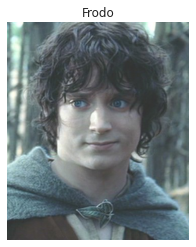

In [ ]:
# show a random image
show_img(PATH)

In [ ]:
# check how many images were saved after dropping broken images
data_summary, data_df = investigate(PATH + '/data')
data_summary

name  length
0         aragorn      91
1         legolas      96
2           gimli      95
3           frodo      94
4  samwise gamgee      94

## **Create train/test sets**
Using splitfolders, split the "data" folder and store train/val sets in the "output" folder. Both "data" and "output" folders are going to be on the same level (when you check folder structure). 

It's important to have train/val split in a separate folder, because they're not the final versions of those sets. You'll see what it means under "Image duplicate finder".

In [ ]:
# split a folder with 80-20 ratio
splitfolders.ratio(PATH + '/data', output=PATH + '/output', 
                   seed=1337, ratio=(.8, .2), 
                   group_prefix=None) # default values

Copying files: 470 files [00:06, 67.33 files/s]


## **Train** 

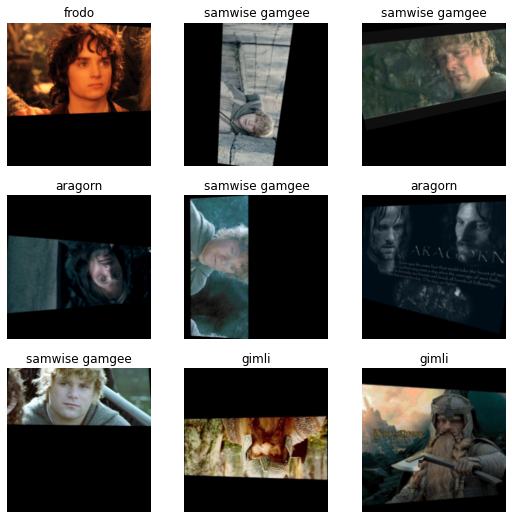

In [ ]:
# show random batch to verify transformations
dls = get_data_loader(PATH)
dls.train.show_batch()

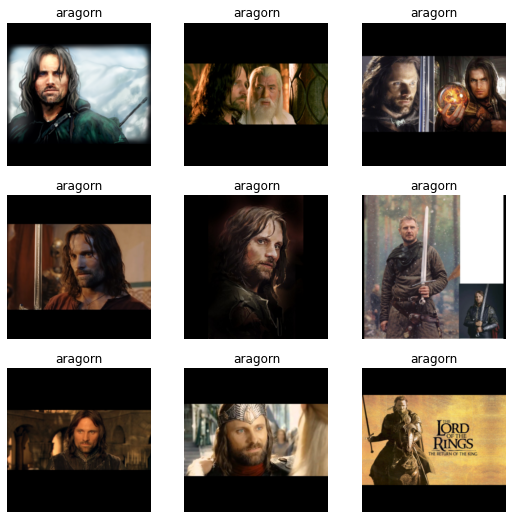

In [ ]:
# show validation set
dls.valid.show_batch()


  ===== Start training =====
  Epochs: 10
  Model: resnet50
  Freeze epochs: 3
  Batch size: 16
  


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Better model found at epoch 0 with f1_score value: 0.6426744915276311.


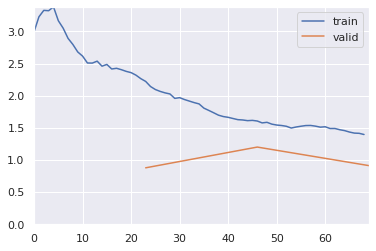

Better model found at epoch 1 with f1_score value: 0.6600543795230702.
Better model found at epoch 2 with f1_score value: 0.7532224911431478.


Better model found at epoch 0 with f1_score value: 0.7978721278721278.


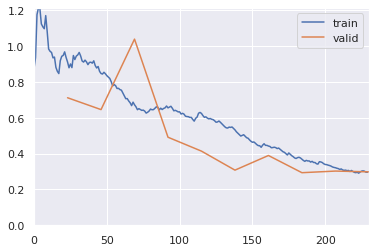

Better model found at epoch 1 with f1_score value: 0.808982608982609.
Better model found at epoch 3 with f1_score value: 0.8604587781058368.
Better model found at epoch 4 with f1_score value: 0.9051436946173789.
Better model found at epoch 5 with f1_score value: 0.9057041251778095.
Better model found at epoch 9 with f1_score value: 0.914998565832969.


                precision    recall  f1-score   support

       aragorn       0.90      0.95      0.92        19
         frodo       0.85      0.89      0.87        19
         gimli       0.95      0.95      0.95        19
       legolas       0.95      1.00      0.98        20
samwise gamgee       0.94      0.79      0.86        19

      accuracy                           0.92        96
     macro avg       0.92      0.92      0.91        96
  weighted avg       0.92      0.92      0.92        96

Most confused
                     confused
0  (samwise gamgee, frodo, 3)


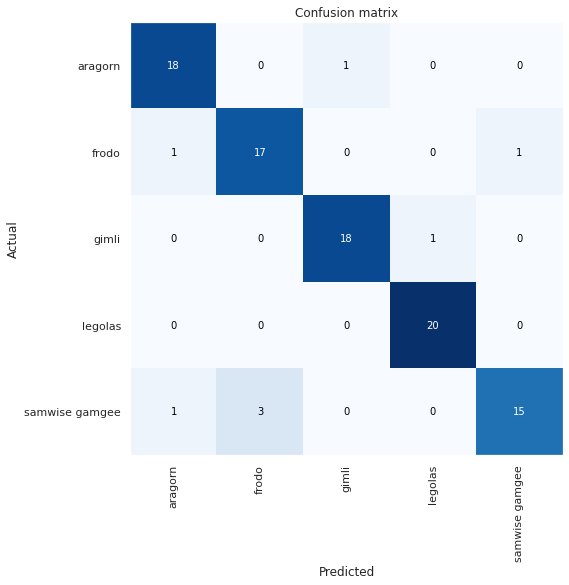

In [ ]:
# train the model (see Utils/Train CNN section for more info)
dls, learner = train_model(PATH, epochs=10)

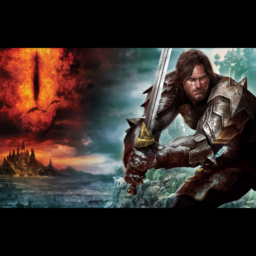

pred: gimli, target: aragorn



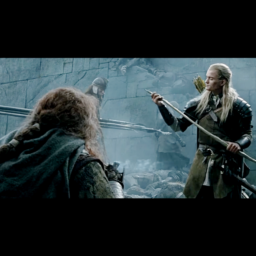

pred: legolas, target: gimli



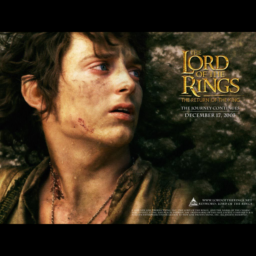

pred: aragorn, target: frodo



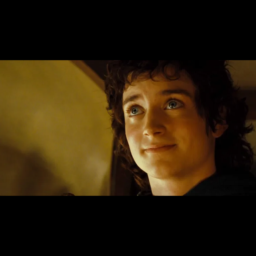

pred: samwise gamgee, target: frodo



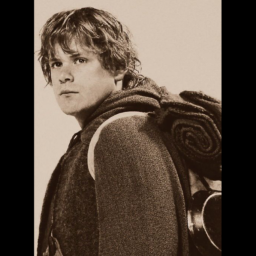

pred: frodo, target: samwise gamgee



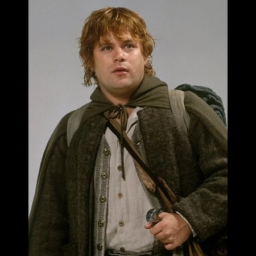

pred: frodo, target: samwise gamgee



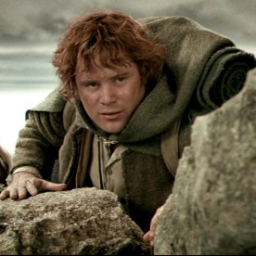

pred: frodo, target: samwise gamgee



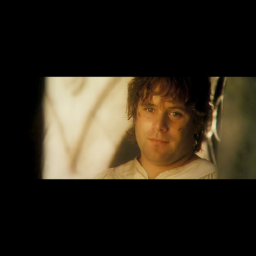

pred: aragorn, target: samwise gamgee



In [ ]:
# check which images were incorrectly classified
plot_misclassified(learner, dls.valid)

## **Dataset cleaning**

Remove images by selecting images only.

 100% |█████████████████| 417/417 [237.2ms elapsed, 0s remaining, 1.8K samples/s]     
 100% |█████████████████| 417/417 [24.5s elapsed, 0s remaining, 28.2 samples/s]      


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


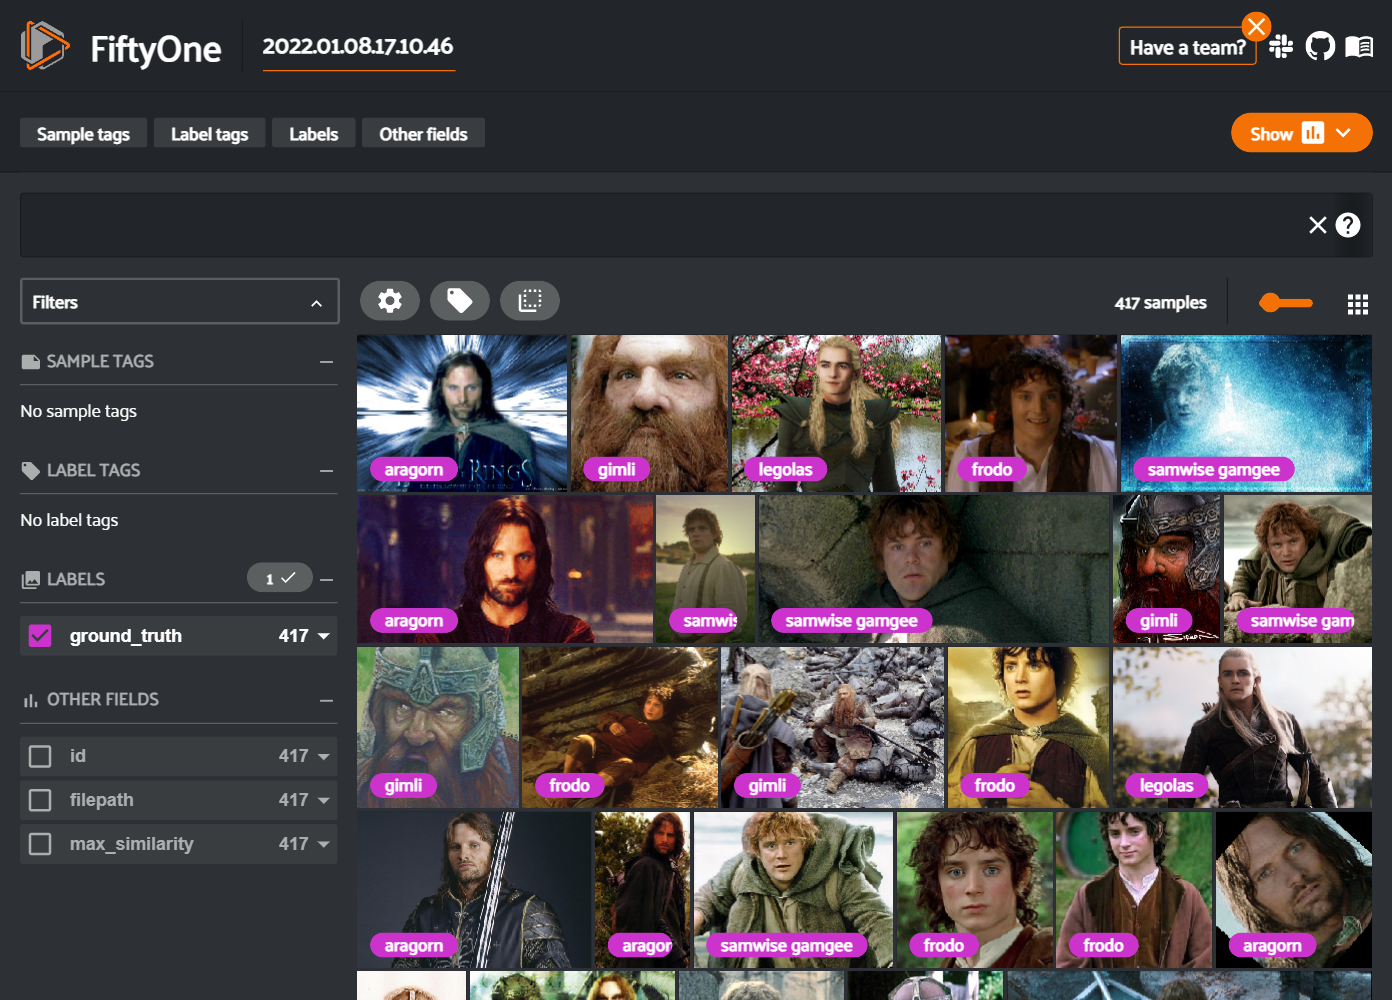

<IPython.core.display.Javascript object>

In [18]:
# run the fiftyone app 
data, similarity_mtx, session = get_similarity(PATH + '/data')

In [ ]:
# drop the images you've selected
data, session = drop_images(data, session)

In [ ]:
# create a set of images to keep
keep_imgs = []

for sample in data.iter_samples():
  keep_imgs.append(sample['filepath'].split('/')[-1])

print(len(keep_imgs))

387


In [ ]:
# iterate over the images and delete the ones that are not
# present in keep_imgs array
for idx, img in data_df.iterrows():
  if img['image_name'] not in keep_imgs:
    path = os.path.join(PATH, 'data', img['class'], img['image_name'])
    os.remove(path)

In [11]:
# check how many images were saved after dropping broken images
data_summary, data_df = investigate(PATH + '/data')
data_summary

name  length
0         aragorn      79
1         legolas      83
2           gimli      65
3           frodo      76
4  samwise gamgee      84

## **Image duplicate finder**

In [16]:
from torchvision import transforms as T

# create random transformations to select from 
tfms = [T.RandomPerspective(distortion_scale=0.3, p=1.0),
        T.RandomRotation(degrees=(0, 180)), T.RandomPosterize(bits=2),
        T.RandomAdjustSharpness(sharpness_factor=2)]

def add_duplicates(path, df, size=30):
  """
  This function selects random N images using selection without replacement.
  After, transforms an image and saves in the folder. 
    :param path: Path to a folder with downloaded images 
    :param df:   DataFrame created using "investigate" function
    :param size: Number of images to generate
  """

  # get SIZE number of images w/o replacement
  images = np.random.choice(df['image_name'], size=size, replace=False)

  for img in images:
    new_path = get_path(path, df, img)
    image = Image.open(new_path)

    # make some transformations and save new image
    image = np.random.choice(tfms, size=1)[0](image)
    new_path = new_path.split('.')[0] + '_copy_.png'
    image.save(new_path)

def get_path(path, df, img):
  im = df[df['image_name'] == img]
  return os.path.join(path, 'data', 
                      im['class'].values[0], 
                      im['image_name'].values[0])


In [13]:
# add 30 duplicates 
add_duplicates(PATH, data_df)

In [13]:
# check if number of images indeed increased
data_summary, data_df = investigate(PATH + '/data')
data_summary

name  length
0         aragorn      88
1         legolas      88
2           gimli      68
3           frodo      84
4  samwise gamgee      89

### **Use FiftyOne app to get unique images**

In [19]:
# load data
data, similarity_mtx, session = get_similarity(PATH + '/data') 

# compute uniqueness 
fob.compute_uniqueness(data)

Output hidden; open in https://colab.research.google.com to view.

In [21]:
dups_view = data.sort_by("uniqueness")
session = fo.launch_app(dups_view)

In [112]:
# create an empty df to store results
potential_dups = pd.DataFrame()

# iterate over the first 70 images and 
# set the stage to get duplicates images
for content in data.sort_by('max_similarity', reverse=True)[:70]:
  potential_dups = potential_dups.append({
      'class': content['ground_truth']['label'],
      'image_name': content['filepath'].split('/')[-1],
      'max_similarity': round(content['max_similarity'], 10),
      'similar_to': None,
      'to_drop': False
  }, ignore_index=True) # make sure to set ignore_index to True!

In [1]:
def get_dup(image, df, path):
  """
  This function calculates the similarities between images using average hashing.
    :param image: Single-instance image row that needs to be checked against 
    :param df: DataFrame with all of the information 
    :param path: Path to a folder (needed for average hash calculations)
   
  :return: An index of the duplicated image
  """
  img_hash = read_hash(os.path.join(path, 'data', image['class'], image['image_name']))
  
  for idx, img in df.iterrows(): 
    if img['image_name'] != image['image_name']:   
      hash = read_hash(os.path.join(path, 'data', img['class'], img['image_name']))
      if img_hash == hash and image['to_drop'] == False and img['to_drop'] == False:
        return idx

def read_hash(img_path):
  """
  This function returns an average hashed value which find near 100% duplicates.
    :param img_path: Path to an image

  :return: Average-hashed image 
  """
  return imagehash.average_hash(Image.open(img_path))

In [114]:
for idx, group in potential_dups.groupby('max_similarity'):
  if group.shape[0] == 2:
    current = potential_dups[potential_dups['image_name'] == group.iloc[0, 1]]
    dup = potential_dups[potential_dups['image_name'] == group.iloc[1, 1]]

    potential_dups.iloc[current.index, 3] = dup['image_name'].values[0]
    potential_dups.iloc[dup.index, 3] = current['image_name'].values[0]
    potential_dups.iloc[dup.index, 4] = True

  else:
    if np.mean(group['max_similarity'] == 1.0):
      for idx, image in group.iterrows():
        if not potential_dups.iloc[idx, 3]:
          dup_idx = get_dup(image, potential_dups, PATH)
          potential_dups.iloc[idx, 3] = group.iloc[dup_idx, 1]
          potential_dups.iloc[idx, 4] = True
          potential_dups.iloc[dup_idx, 3] = image['image_name']


Check how many images are without any pairs. Make sure the images without pairs are not set for dropping. Finally, count the number of images that were actually considered a duplicate with average hashing. 

In [115]:
potential_dups[potential_dups['similar_to'].isna()]

class  \
44  frodo   
57  frodo   
66  gimli   
69  gimli   

                                                                 image_name  \
44                               88793d30b960eb00839bceb64661496a_large.jpg   
57                      Frodo-Sam-image-frodo-and-sam-36091809-1920-796.jpg   
66  the-lord-of-the-rings-gimli-sixth-scale-figure-asmus-toys-903529-05.jpg   
69                                                            wp2166358.jpg   

    max_similarity similar_to to_drop  
44        0.942143       None       0  
57        0.934714       None       0  
66        0.929037       None       0  
69        0.928064       None       0

In [116]:
len(potential_dups[potential_dups['to_drop'] == True])

33

In [117]:
# remove the duplicates
for idx, image in potential_dups[potential_dups['to_drop'] == True].iterrows():
  path = os.path.join(PATH, 'data', image['class'], image['image_name'])
  os.remove(path)

In [118]:
# check if number of images indeed removed
data_summary, data_df = investigate(PATH + '/data')
data_summary

name  length
0         aragorn      79
1         legolas      84
2           gimli      64
3           frodo      77
4  samwise gamgee      80

 100% |█████████████████| 384/384 [255.5ms elapsed, 0s remaining, 1.5K samples/s]     
 100% |████|  108.4Mb/108.4Mb [309.0ms elapsed, 0s remaining, 351.0Mb/s]      
 100% |█████████████████| 384/384 [4.8m elapsed, 0s remaining, 1.5 samples/s]      


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


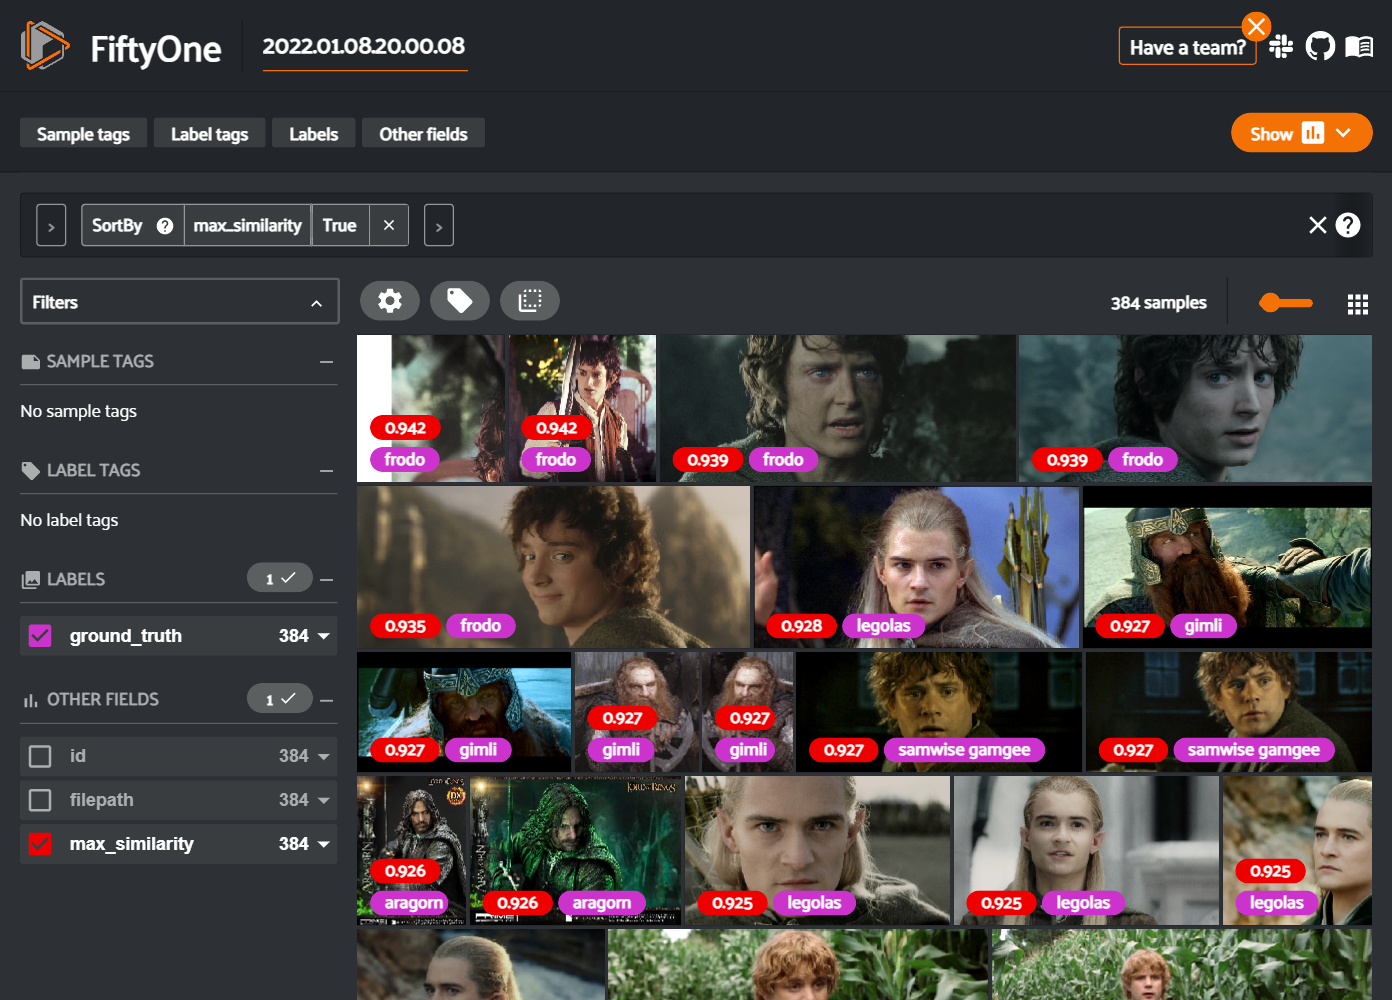

<IPython.core.display.Javascript object>

In [15]:
# load data
data, similarity_mtx, session = get_similarity(PATH + '/data') 

In [17]:
session.freeze()